In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=64)

In [5]:
rho = 0.05
num_epochs = 30

train_log = []
test_log = []

## Задание 1. Реализовать сверточный автокодировщик.

In [18]:
# Conv + FC

class Encoder(nn.Module):
    def __init__(self, latent_size=64):
        super(Encoder, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 4 * 4, latent_size)
    
    def forward(self, x):
        # batch_size x 1 x 28 x 28
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        # batch_size x 8 x 12 x 12
        x = self.bn2(F.relu(self.conv2(x)))
        # batch_size x 16 x 10 x 10
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        # batch_size x 32 x 4 x 4
        x = x.view(-1, 32 * 4 * 4)
        # batch_size x 512
        x = F.sigmoid(self.fc1(x))
        # batch_size x latent_size
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=64):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 32 * 4 * 4)
        self.tconv1 = nn.ConvTranspose2d(32, 16, 5, 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.tconv2 = nn.ConvTranspose2d(16, 8, 5, 2)
        self.bn2 = nn.BatchNorm2d(8)
        self.tconv3 = nn.ConvTranspose2d(8, 1, 4)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        # batch_size x latent_size
        x = x.view(-1, 32, 4, 4)
        # batch_size x 32 x 4 x 4
        x = self.bn1(F.relu(self.tconv1(x)))
        # batch_size x 16 x 11 x 11
        x = self.bn2(F.relu(self.tconv2(x)))
        # batch_size x 8 x 25 x 25
        x = F.tanh(self.tconv3(x))
        # batch_size x 3 x 28 x 28
        return x

In [19]:
class Net(nn.Module):
    def __init__(self, latent_size=64, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None

        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
        
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = -p * log(q) - (1 - p) * log(1- q)
        """
        dkl = - rho * torch.log(self.data_rho) - (1 - rho) * torch.log(1 - self.data_rho)

        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss

    def loss(self, x, target, **kwargs):
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss    

In [20]:
model = Net()

In [21]:
def train(epoch, model, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        model.optim.zero_grad()
        data = data.to(device)
        output = model(data)
        rho_loss = model.rho_loss(rho)
        loss = model.loss(output, data) + rho_loss
        loss.backward()
        model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            train_loss = '{:.6f}'.format(model._loss.item())
            print(line + train_loss)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        train_loss = '{:.6f}'.format(model._loss.item())
        if log:
            log.append((models._loss, models._rho_loss))
        print(line + train_loss)

In [22]:
avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'Rho loss: {:.4f}'.format(p)
line = lambda l, p: avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(model, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = 0
    rho_loss = 0
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = model(data)
            test_loss += model.loss(output, data, size_average=False).item() # sum up batch loss
            rho_loss += model.rho_loss(rho, size_average=False).item()
    
    test_loss /= (test_size * 784)
    rho_loss /= (test_size * model.latent_size)
    if log:
        log.append((test_loss, rho_loss))
    
    lines = '\n'.join([line(test_loss, rho_loss)]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [23]:
for epoch in range(1, num_epochs + 1):
    model = model.to(device)
    model.train()
    train(epoch, model, train_log)
    model.eval()
    test(model, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Loss 0.998534
Train Epoch: 1 [12800/50000 (26%)]	Loss 0.609709
Train Epoch: 1 [25600/50000 (51%)]	Loss 0.357500
Train Epoch: 1 [38400/50000 (77%)]	Loss 0.238391
Train Epoch: 1 [12512/50000 (100%)]	Loss 0.213171
Test set:
Loss: 0.1873	Rho loss: 0.0031

Train Epoch: 2 [0/50000 (0%)]	Loss 0.187693
Train Epoch: 2 [12800/50000 (26%)]	Loss 0.157157
Train Epoch: 2 [25600/50000 (51%)]	Loss 0.111905
Train Epoch: 2 [38400/50000 (77%)]	Loss 0.103372
Train Epoch: 2 [12512/50000 (100%)]	Loss 0.083931
Test set:
Loss: 0.0907	Rho loss: 0.0031

Train Epoch: 3 [0/50000 (0%)]	Loss 0.087100
Train Epoch: 3 [12800/50000 (26%)]	Loss 0.078765
Train Epoch: 3 [25600/50000 (51%)]	Loss 0.067976
Train Epoch: 3 [38400/50000 (77%)]	Loss 0.073053
Train Epoch: 3 [12512/50000 (100%)]	Loss 0.080870
Test set:
Loss: 0.0646	Rho loss: 0.0031

Train Epoch: 4 [0/50000 (0%)]	Loss 0.061452
Train Epoch: 4 [12800/50000 (26%)]	Loss 0.051230
Train Epoch: 4 [25600/50000 (51%)]	Loss 0.055456
Train Epoch:

In [52]:
data, _ = next(iter(test_loader))
output = model(data.to(device))

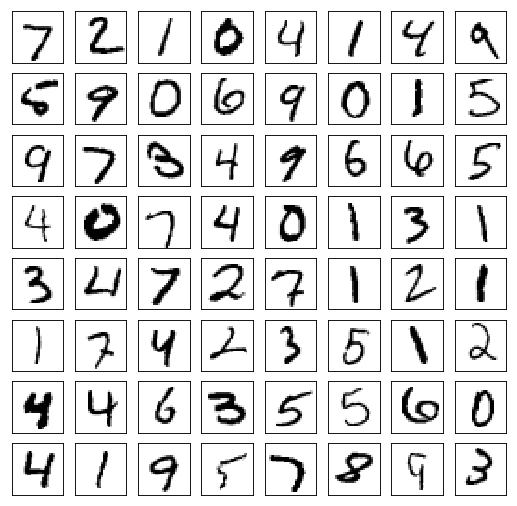

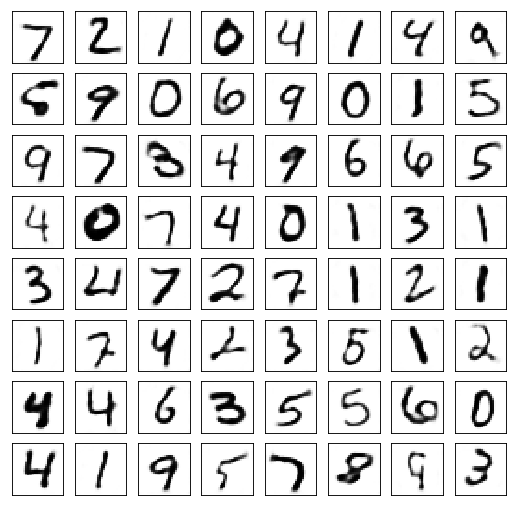

In [53]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(output.data.cpu().numpy(), (8, 8))

## Задание 3. Сделать оптимизацию изображения под активацию сверточных нейронов автокодировщика.

In [69]:
img, _ = next(iter(test_loader))
img = nn.Parameter(img)
img_opt = optim.Adam(params=[img], lr=1e-4)

Loss: 0.0107193328


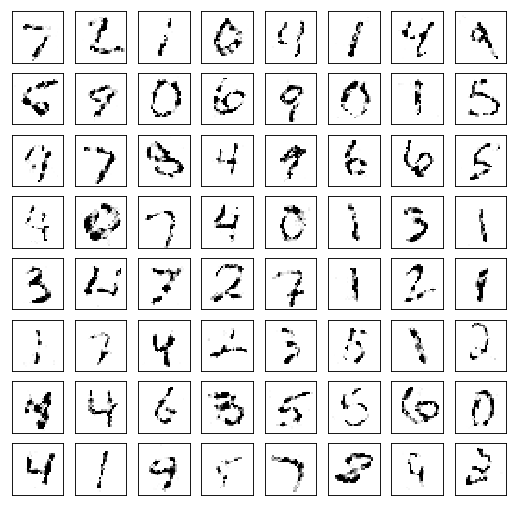

Loss: 0.0056198845


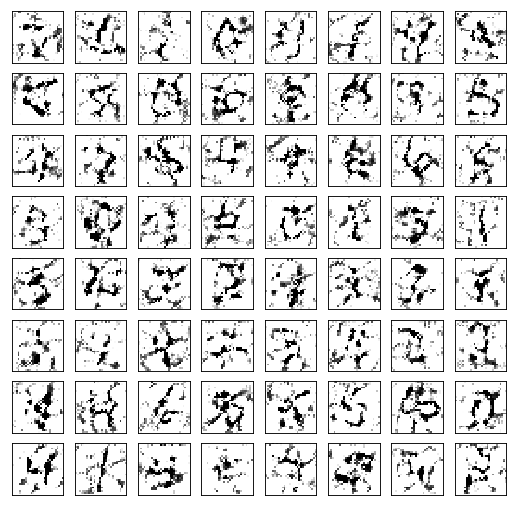

Loss: 0.0030550777


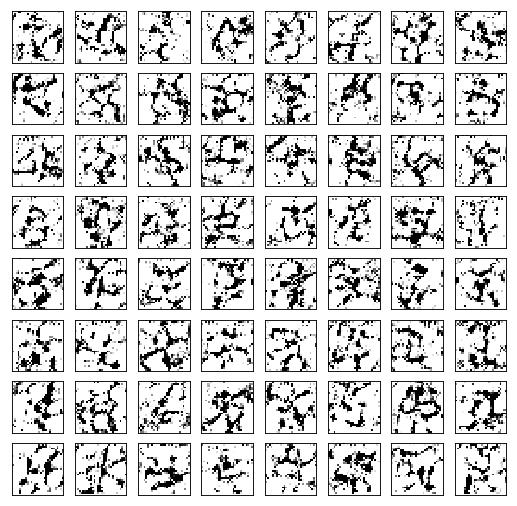

Loss: 0.0017448537


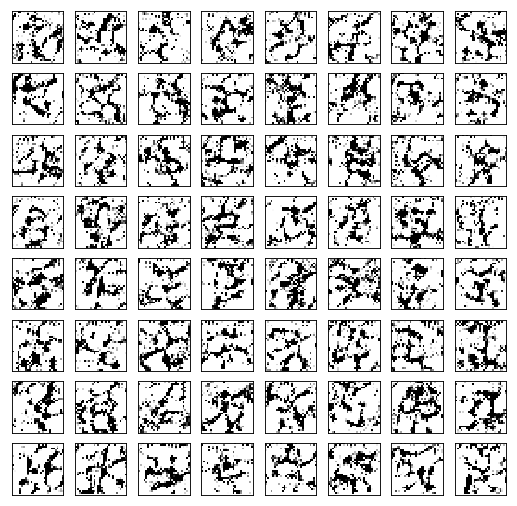

Loss: 0.0010577558


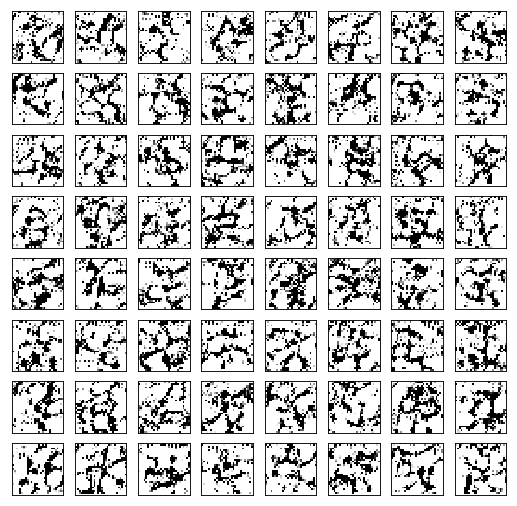

Loss: 0.0006756430


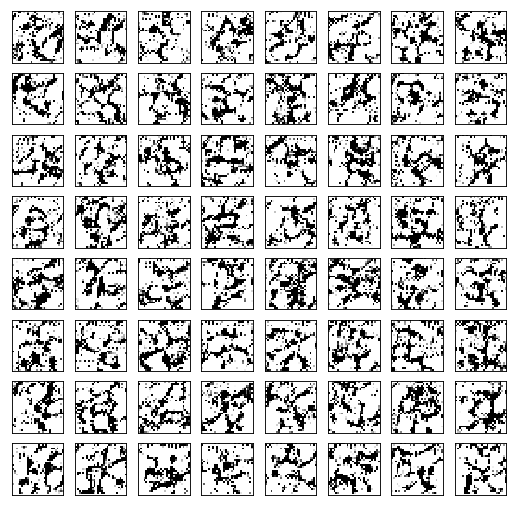

Loss: 0.0004580435


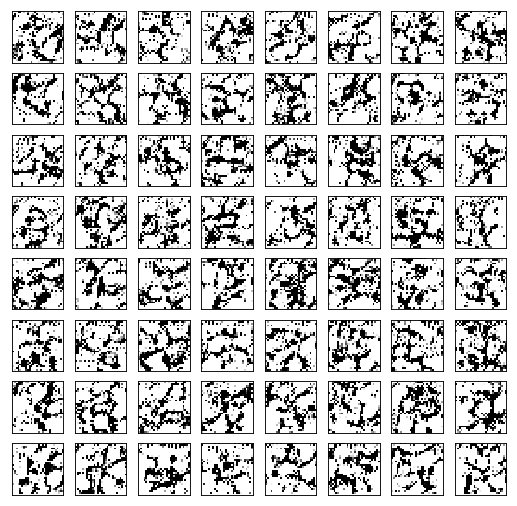

Loss: 0.0003260504


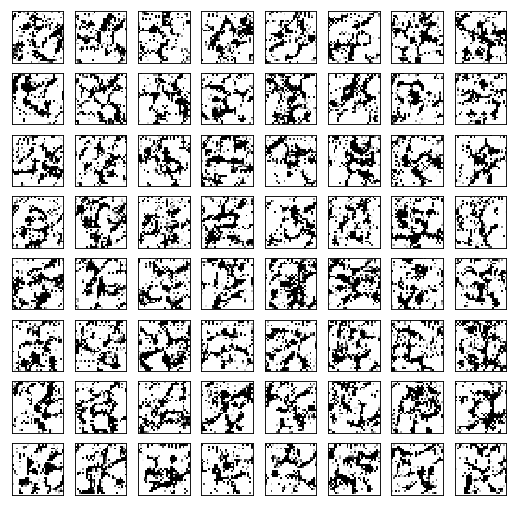

Loss: 0.0002425648


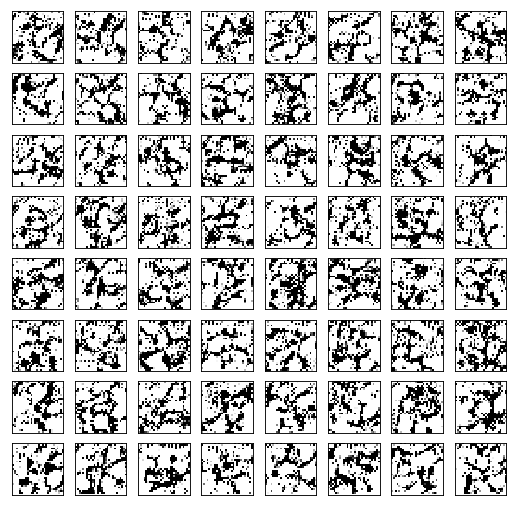

Loss: 0.0001871339


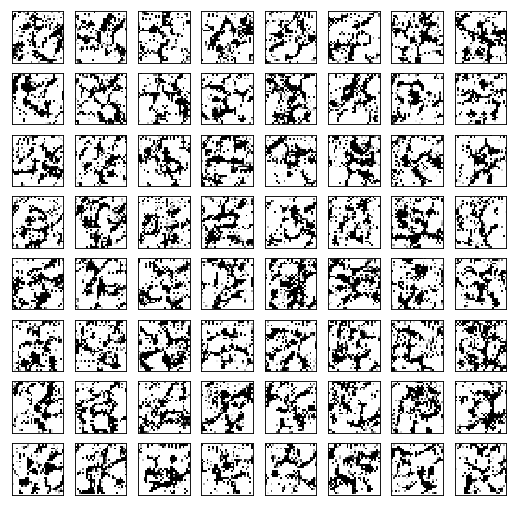

In [70]:
# image optimization based on FC layer activations
for i in range(1, 100001):
    img_opt.zero_grad()
    encoded = model.E(img.to(device))
    img_loss = F.mse_loss(encoded, torch.eye(64).to(device))
    img_loss.backward()
    img_opt.step()
    
    if i % 10000 == 0:
        print(f'Loss: {img_loss.item():.10f}')
        plot_mnist(img.clamp(0, 1).data.numpy(), (8, 8))

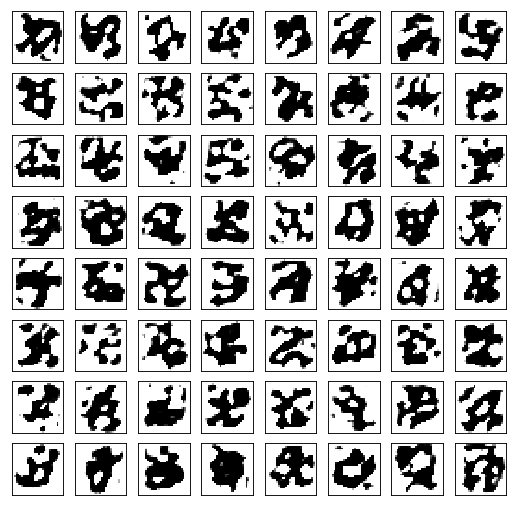

In [83]:
# decoding the encoded optimized images
decoded = model.decode(encoded)
plot_mnist(decoded.data.cpu().clamp(0, 1).numpy(), (8, 8))

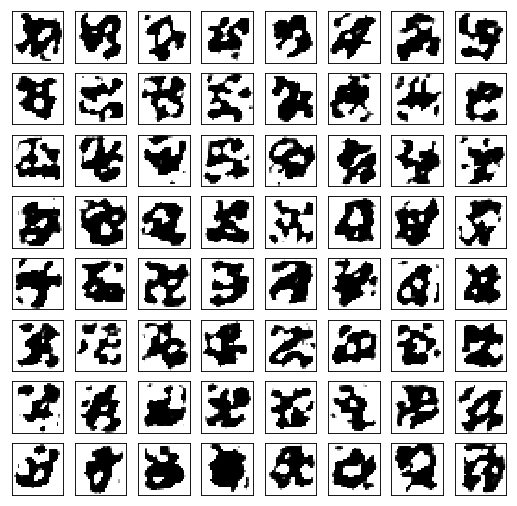

In [84]:
# decoding the 64x64 identity matrix
decoded_oh = model.decode(torch.eye(64).to(device))
plot_mnist(decoded_oh.data.cpu().clamp(0, 1).numpy(), (8, 8))

In [214]:
# purely convolutional autoencoder

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3)
    
    def forward(self, x):
        # batch_size x 1 x 28 x 28
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        # batch_size x 8 x 12 x 12
        x = self.bn2(F.relu(self.conv2(x)))
        # batch_size x 16 x 10 x 10
        x = self.pool(F.sigmoid(self.conv3(x)))
        # batch_size x 32 x 4 x 4
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tconv1 = nn.ConvTranspose2d(32, 16, 5, 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.tconv2 = nn.ConvTranspose2d(16, 8, 5, 2)
        self.bn2 = nn.BatchNorm2d(8)
        self.tconv3 = nn.ConvTranspose2d(8, 1, 4)
    
    def forward(self, x):
        # batch_size x 32 x 4 x 4
        x = self.bn1(F.relu(self.tconv1(x)))
        # batch_size x 16 x 11 x 11
        x = self.bn2(F.relu(self.tconv2(x)))
        # batch_size x 8 x 25 x 25
        x = F.tanh(self.tconv3(x))
        # batch_size x 3 x 28 x 28
        return x

In [215]:
class Net(nn.Module):
    def __init__(self, latent_size=64, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder()
        self.D = Decoder()
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None

        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def conv(self, x):
        x = self.E.pool(self.E.bn1(F.relu(self.E.conv1(x))))
        x = self.E.bn2(F.relu(self.E.conv2(x)))
        x = self.E.pool(F.sigmoid(self.E.conv3(x)))
        return x
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
        
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = -p * log(q) - (1 - p) * log(1- q)
        """
        dkl = - rho * torch.log(self.data_rho) - (1 - rho) * torch.log(1 - self.data_rho)

        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss

    def loss(self, x, target, **kwargs):
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss  

In [216]:
model2 = Net()

In [217]:
for epoch in range(1, num_epochs + 1):
    model2 = model2.to(device)
    model2.train()
    train(epoch, model2)
    model2.eval()
    test(model2, valid_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss 1.091994
Train Epoch: 1 [12800/50000 (26%)]	Loss 0.548534
Train Epoch: 1 [25600/50000 (51%)]	Loss 0.281215
Train Epoch: 1 [38400/50000 (77%)]	Loss 0.168165
Train Epoch: 1 [12512/50000 (100%)]	Loss 0.117106
Test set:
Loss: 0.1122	Rho loss: 0.0486

Train Epoch: 2 [0/50000 (0%)]	Loss 0.122726
Train Epoch: 2 [12800/50000 (26%)]	Loss 0.096885
Train Epoch: 2 [25600/50000 (51%)]	Loss 0.066032
Train Epoch: 2 [38400/50000 (77%)]	Loss 0.059478
Train Epoch: 2 [12512/50000 (100%)]	Loss 0.051199
Test set:
Loss: 0.0502	Rho loss: 0.0272

Train Epoch: 3 [0/50000 (0%)]	Loss 0.054356
Train Epoch: 3 [12800/50000 (26%)]	Loss 0.043072
Train Epoch: 3 [25600/50000 (51%)]	Loss 0.038488
Train Epoch: 3 [38400/50000 (77%)]	Loss 0.035394
Train Epoch: 3 [12512/50000 (100%)]	Loss 0.033684
Test set:
Loss: 0.0341	Rho loss: 0.0251

Train Epoch: 4 [0/50000 (0%)]	Loss 0.033304
Train Epoch: 4 [12800/50000 (26%)]	Loss 0.031116
Train Epoch: 4 [25600/50000 (51%)]	Loss 0.030825
Train Epoch:

In [218]:
img2, _ = next(iter(test_loader))
output2 = model2(img2.to(device))

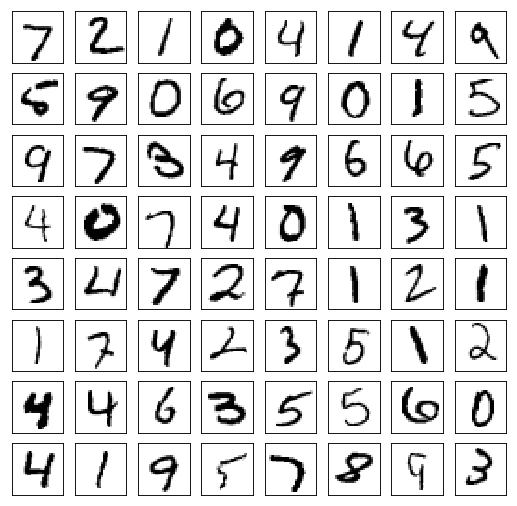

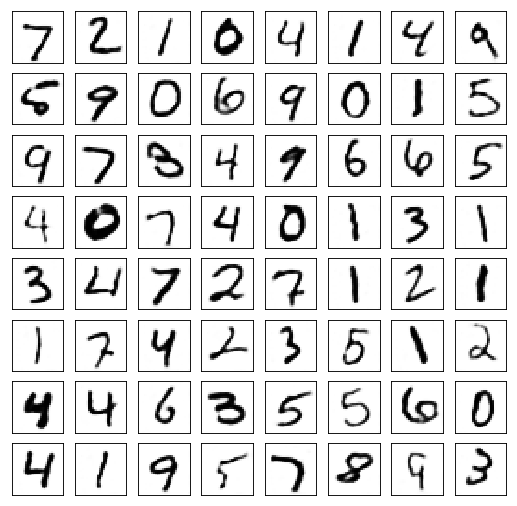

In [219]:
# plotting original images and those reconstructed by ConvAE
plot_mnist(img2.data.numpy(), (8, 8))
plot_mnist(output2.data.cpu().numpy(), (8, 8))

In [220]:
img_transform = transforms.Compose([
                transforms.Resize((16, 16)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
           ])
_, _, test_loader2 = mnist(valid=10000, batch_size=32, transform=img_transform)

In [221]:
img3, _ = next(iter(test_loader2))
img3 = nn.Parameter(img3)
img_opt3 = optim.Adam(params=[img3], lr=1e-4)

Loss: 0.0269979313


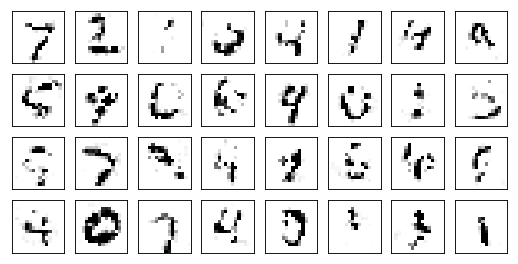

Loss: 0.0227723587


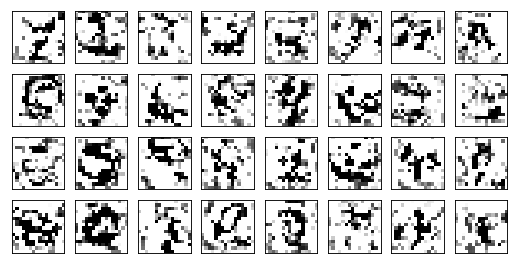

Loss: 0.0180313308


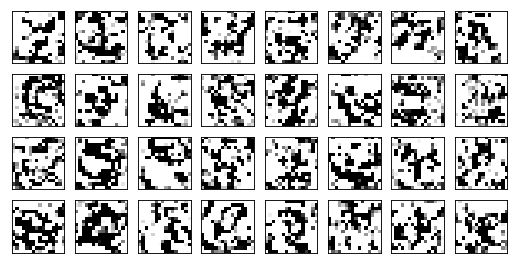

Loss: 0.0135366805


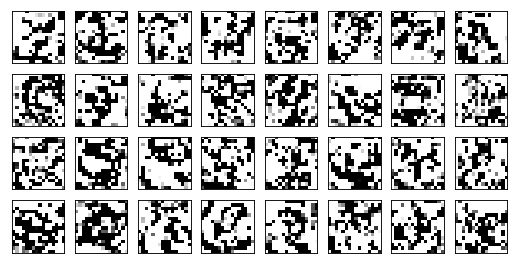

Loss: 0.0098879617


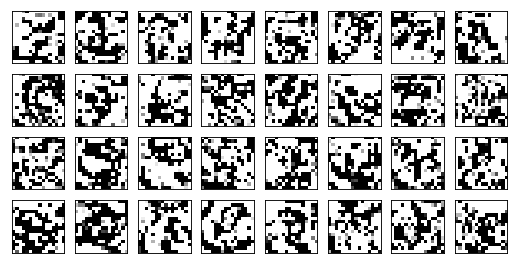

Loss: 0.0072081969


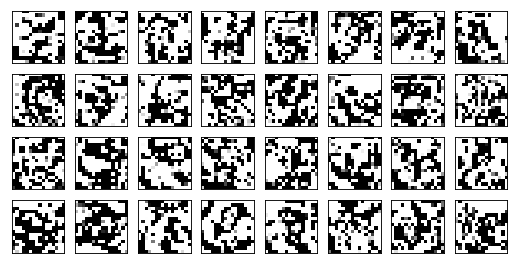

Loss: 0.0053105815


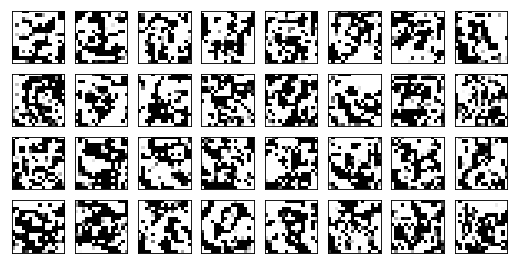

Loss: 0.0039583002


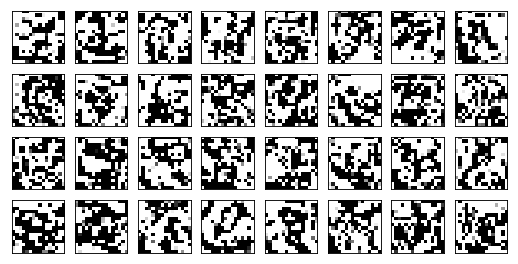

Loss: 0.0029896535


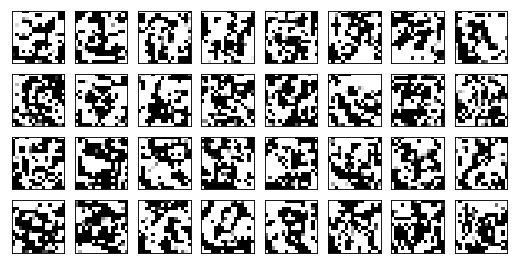

Loss: 0.0022793058


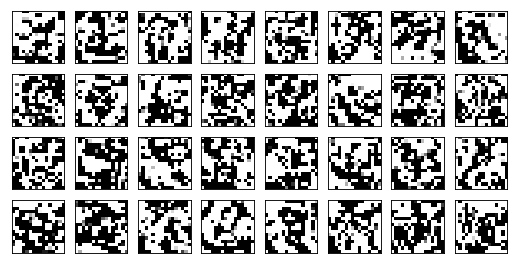

In [222]:
# image optimization based on convolutional layer activations
for i in range(1, 100001):
    img_opt3.zero_grad()
    encoded3 = model2.conv(img3.to(device))
    img_loss3 = F.mse_loss(encoded3.view(-1, 32), torch.eye(32).to(device))
    img_loss3.backward()
    img_opt3.step()
    
    if i % 10000 == 0:
        print(f'Loss: {img_loss3.item():.10f}')
        plot_mnist(img3.clamp(0, 1).data.numpy(), (4, 8))

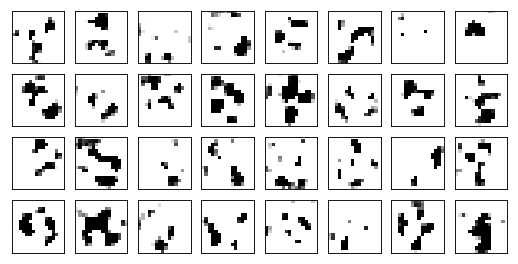

In [224]:
# decoding the encoded optimized images
decoded_conv = model2.decode(encoded3)
plot_mnist(decoded_conv.data.cpu().clamp(0, 1).numpy(), (4, 8))

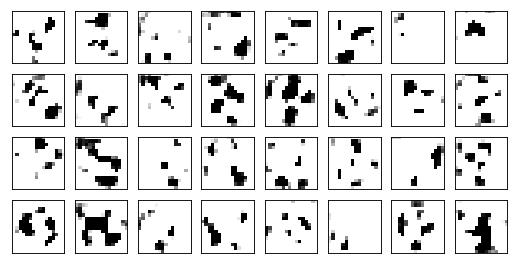

In [227]:
# decoding the 32x32 identity matrix
decoded_oh_conv = model2.decode(torch.eye(32).view(32, 32, 1, 1).to(device))
plot_mnist(decoded_oh_conv.data.cpu().clamp(0, 1).numpy(), (4, 8))

## Задание 2. Сделать оптимизацию изображения под активацию сверточных нейронов классификатора.

In [228]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(*size, padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [229]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [230]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [235]:
models = {'model3': Net(True)}
train_log = {m: [] for m in models}
test_log = {m: [] for m in models}

In [238]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [239]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [240]:
for epoch in range(1, num_epochs + 1):
    for model in models.values():
        model = model.to(device)
        model.train()
    train(epoch, models, train_log)
    model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses model3: 2.324677
Train Epoch: 1 [12800/50000 (26%)]	Losses model3: 2.013040
Train Epoch: 1 [25600/50000 (51%)]	Losses model3: 1.596560
Train Epoch: 1 [38400/50000 (77%)]	Losses model3: 1.335863
Train Epoch: 1 [12512/50000 (100%)]	Losses model3: 0.927612
Test set:
model3: Loss: 1.0550	Accuracy: 8872.0/10000 (89%)

Train Epoch: 2 [0/50000 (0%)]	Losses model3: 1.139029
Train Epoch: 2 [12800/50000 (26%)]	Losses model3: 0.712976
Train Epoch: 2 [25600/50000 (51%)]	Losses model3: 0.629669
Train Epoch: 2 [38400/50000 (77%)]	Losses model3: 0.593312
Train Epoch: 2 [12512/50000 (100%)]	Losses model3: 0.469571
Test set:
model3: Loss: 0.5144	Accuracy: 9257.0/10000 (93%)

Train Epoch: 3 [0/50000 (0%)]	Losses model3: 0.618329
Train Epoch: 3 [12800/50000 (26%)]	Losses model3: 0.563647
Train Epoch: 3 [25600/50000 (51%)]	Losses model3: 0.340297
Train Epoch: 3 [38400/50000 (77%)]	Losses model3: 0.360424
Train Epoch: 3 [12512/50000 (100%)]	Losses model3: 0.203438
Test 

In [257]:
_, _, test_loader3 = mnist(valid=10000, batch_size=32)

In [258]:
img4, _ = next(iter(test_loader3))
img4 = nn.Parameter(img4)
img_opt4 = optim.Adam(params=[img4], lr=1e-4)

Loss: 0.1157794222


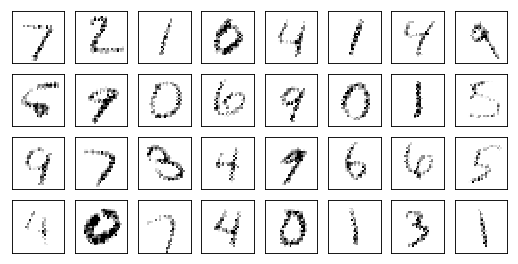

Loss: 0.1041261181


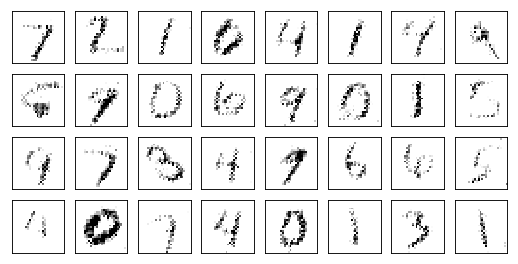

Loss: 0.1003223062


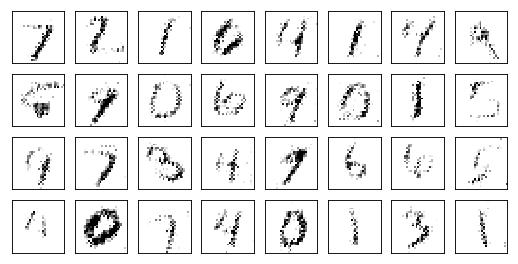

Loss: 0.0984886736


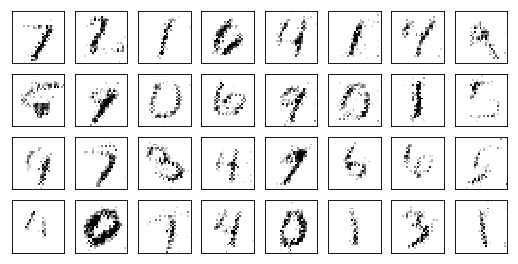

Loss: 0.0973328650


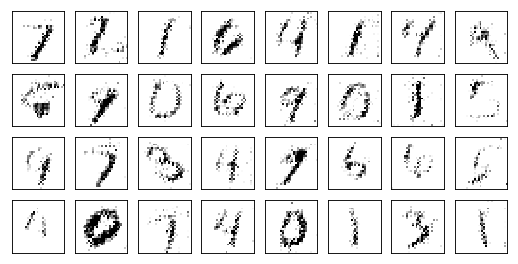

Loss: 0.0964207128


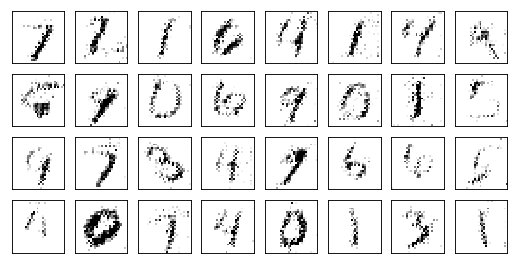

Loss: 0.0957071856


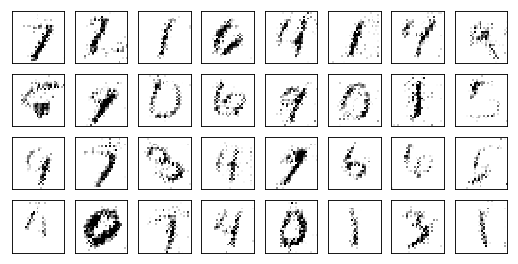

Loss: 0.0951209441


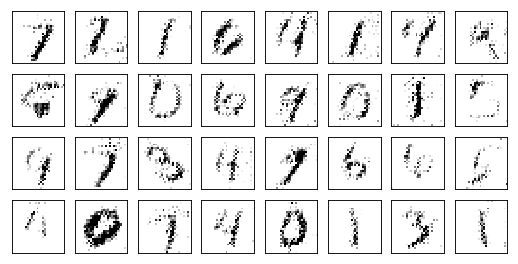

Loss: 0.0946008265


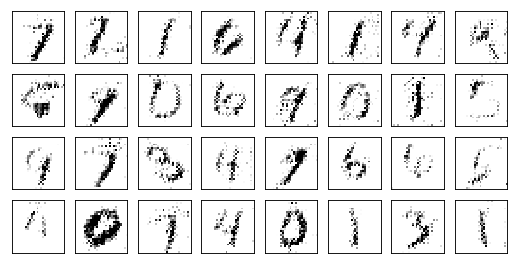

Loss: 0.0942288637


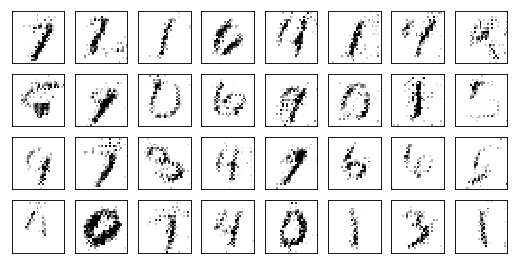

In [259]:
# image optimization based on convolutional layer activations
for i in range(1, 100001):
    img_opt4.zero_grad()
    encoded4 = models['model3'].conv(img4.to(device))
    img_loss4 = F.mse_loss(encoded4.mean(2).mean(2), torch.eye(32).to(device))
    img_loss4.backward()
    img_opt4.step()
    
    if i % 10000 == 0:
        print(f'Loss: {img_loss4.item():.10f}')
        plot_mnist(img4.clamp(0, 1).data.numpy(), (4, 8))